# Desarrollo de un pipeline

In [1]:
from data.image_converter import get_images

images_yes, images_no = get_images(image_size=(224, 224))

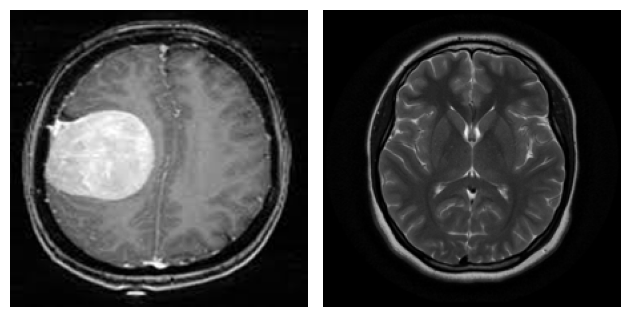

In [27]:
import numpy as np
import matplotlib.pyplot as plt

im_yes = images_yes[0]
im_no = images_no[0]

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(im_yes, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(im_no, cmap='gray')
plt.axis('off')
plt.tight_layout()

In [ ]:
from gtda.images import RadialFiltration

radial_filtration = RadialFiltration(center=np.array([196, 196]), n_jobs=-1)
im_yes = im_yes[None, :, :]
im_no = im_no[None, :, :]

im_yes_radial = radial_filtration.fit_transform(im_yes)
im_yes_radial_plot = radial_filtration.plot(im_yes_radial, colorscale='jet')

im_no_radial = radial_filtration.fit_transform(im_no)
im_no_radial_plot = radial_filtration.plot(im_no_radial, colorscale='jet')

fig = make_subplots(rows=1, cols=2, subplot_titles=['Con tumor', 'Sin tumor'])
fig.update_layout(width=600, height=350)
fig.add_trace(im_yes_radial_plot['data'][0], row=1, col=1)
fig.add_trace(im_no_radial_plot['data'][0], row=1, col=2)
fig

In [ ]:
from gtda.homology import CubicalPersistence
from gtda.diagrams import Scaler

cubical_pesistence = CubicalPersistence(n_jobs=-1)
scaler = Scaler(n_jobs=-1)

im_yes_cubical = cubical_pesistence.fit_transform(im_yes_radial)
im_yes_cubical_scaled = scaler.fit_transform(im_yes_cubical)
im_yes_cubical_scaled_plot = scaler.plot(im_yes_cubical_scaled, 
                                         plotly_params={'layout':{'title':'Diagrama de persistencia de un cerebro con tumor'}})

im_no_cubical = cubical_pesistence.fit_transform(im_no_radial)
im_no_cubical_scaled = scaler.fit_transform(im_no_cubical)
im_no_cubical_scaled_plot = scaler.plot(im_no_cubical_scaled, 
                                       plotly_params={'layout':{'title':'Daiagrama de persistencia de un cerebro sin tumores'}})

im_yes_cubical_scaled_plot.show()
im_no_cubical_scaled_plot.show()

In [ ]:
from gtda.diagrams import HeatKernel

heat_kernel = HeatKernel(sigma=0.15, n_bins=60, n_jobs=-1)

im_yes_cubical_heat = heat_kernel.fit_transform(im_yes_cubical_scaled)
im_no_cubical_heat = heat_kernel.fit_transform(im_no_cubical_scaled)

im_yes_cubical_heat_plot = heat_kernel.plot(im_yes_cubical_heat, homology_dimension_idx=1, colorscale='jet')
im_no_cubical_heat_plot = heat_kernel.plot(im_no_cubical_heat, homology_dimension_idx=1, colorscale='jet')

fig = make_subplots(rows=1, cols=2, subplot_titles=['Con tumor', 'Sin tumor'])
fig.add_trace(im_yes_cubical_heat_plot['data'][0], row=1, col=1)
fig.add_trace(im_no_cubical_heat_plot['data'][0], row=1, col=2)
fig.update_layout(width=800, height=400)

In [ ]:
%%time
fig = make_subplots(rows=3, cols=10)

for threshold in range(1, 10):
    binarizer = Binarizer(threshold=threshold/10, n_jobs=-1)
    im_yes_binarized = binarizer.fit_transform(im_yes.reshape(-1, im_yes.shape[0], im_yes.shape[1]))
    im_yes_binarized_plot = binarizer.plot(im_yes_binarized)

    im_yes_binarized_radial = radial_filtration.fit_transform(im_yes_binarized)
    im_yes_binarized_radial_plot = radial_filtration.plot(im_yes_binarized_radial, colorscale='jet')
    
    im_yes_cubical = cubical_pesistence.fit_transform(im_yes_binarized_radial)
    im_yes_cubical_scaled = scaler.fit_transform(im_yes_cubical)
    im_yes_cubical_heat = heat_kernel.fit_transform(im_yes_cubical_scaled)
    im_yes_cubical_heat_plot = heat_kernel.plot(im_yes_cubical_heat, homology_dimension_idx=1, colorscale='jet')
    
    fig.add_trace(im_yes_binarized_plot['data'][0], row=1, col=threshold)
    fig.add_trace(im_yes_binarized_radial_plot['data'][0], row=2, col=threshold)
    fig.add_trace(im_yes_cubical_heat_plot['data'][0], row=3, col=threshold)
    
fig.update_layout(width=1300, height=600)

In [ ]:
%%time
fig = make_subplots(rows=3, cols=10)

for threshold in range(1, 10):
    binarizer = Binarizer(threshold=threshold/10, n_jobs=-1)
    im_no_binarized = binarizer.fit_transform(im_no.reshape(-1, im_no.shape[0], im_no.shape[1]))
    im_no_binarized_plot = binarizer.plot(im_no_binarized)

    im_no_binarized_radial = radial_filtration.fit_transform(im_no_binarized)
    im_no_binarized_radial_plot = radial_filtration.plot(im_no_binarized_radial, colorscale='jet')

    im_no_cubical = cubical_pesistence.fit_transform(im_no_binarized_radial)
    im_no_cubical_scaled = scaler.fit_transform(im_no_cubical)
    im_no_cubical_heat = heat_kernel.fit_transform(im_no_cubical_scaled)
    im_no_cubical_heat_plot = heat_kernel.plot(im_no_cubical_heat, homology_dimension_idx=1, colorscale='jet')

    fig.add_trace(im_no_binarized_plot['data'][0], row=1, col=threshold)
    fig.add_trace(im_no_binarized_radial_plot['data'][0], row=2, col=threshold)
    fig.add_trace(im_no_cubical_heat_plot['data'][0], row=3, col=threshold)
    
fig.update_layout(width=1300, height=600)

## Diseño de un Pipeline

In [ ]:
from itertools import product
from sklearn.pipeline import make_pipeline, make_union
from sklearn import set_config
from gtda.diagrams import PersistenceEntropy, Amplitude

threshold_iter = np.arange(0.1, 1, 0.1)
#direction_iter = product({1, -1, 0}, {1, -1, 0})
center_iter = product({28, 112 ,196}, {28, 112, 196})

binarizers = ([Binarizer(threshold=threshold, n_jobs=-1) for threshold in threshold_iter])
radial_filtrations = ([RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_iter])

steps = [
    [
        binarizer,
        radial_filtration,
        #HeatKernel(sigma=0.15, n_bins=60, n_jobs=-1),
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1)
    ] for radial_filtration in radial_filtrations
    for binarizer in binarizers
]

metric_iter = [
    {'metric':'bottleneck', 'metric_params':{}},
    {'metric':'wasserstein', 'metric_params':{'p':1}},
    {'metric':'wasserstein', 'metric_params':{'p':2}},
    {'metric':'landscape', 'metric_params':{'p':1, 'n_layers':1, 'n_bins':100}},
    {'metric':'landscape', 'metric_params':{'p':1, 'n_layers':2, 'n_bins':100}},
    {'metric':'landscape', 'metric_params':{'p':2, 'n_layers':1, 'n_bins':100}},
    {'metric':'landscape', 'metric_params':{'p':2, 'n_layers':2, 'n_bins':100}},
    {'metric':'betti', 'metric_params':{'p':1, 'n_bins':100}},
    {'metric':'betti', 'metric_params':{'p':2, 'n_bins':100}},
    {'metric':'heat', 'metric_params':{'p':1, 'sigma':1.6, 'n_bins':100}},
    {'metric':'heat', 'metric_params':{'p':1, 'sigma':3.2, 'n_bins':100}},
    {'metric':'heat', 'metric_params':{'p':2, 'sigma':1.6, 'n_bins':100}},
    {'metric':'heat', 'metric_params':{'p':2, 'sigma':3.2, 'n_bins':100}}
]
amplitudes = ([Amplitude(**metric, n_jobs=-1) for metric in metric_iter])
amplitudes_union = make_union(*[PersistenceEntropy(nan_fill_value=-1)] + amplitudes)

tda_pipeline = make_union(
    *[make_pipeline(*step, amplitudes_union) for step in steps], n_jobs=-1
)

set_config(display='diagram')
tda_pipeline

In [ ]:
%%time
im_yes_aux = im_yes
im_yes_pipeline = tda_pipeline.fit_transform(im_yes_aux)
im_yes_pipeline.shape

In [ ]:
%%time
train_yes_pipeline = tda_pipeline.fit_transform(train_yes)
train_yes_pipeline.shape

In [ ]:
%%time
train_no_pipeline = tda_pipeline.fit_transform(train_no)
train_no_pipeline.shape

In [ ]:
train_pipeline = np.concatenate((train_no_pipeline, train_yes_pipeline))
train_pipeline.shape

In [ ]:
from sklearn.model_selection import train_test_split

X = np.concatenate((tumor_positives, tumor_negatives))
y = np.concatenate((np.ones(tumor_positives.shape[0]), np.zeros(tumor_negatives.shape[0])))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)
X_train.shape, X_test.shape

In [ ]:
%%time
X_train_pipeline = tda_pipeline.fit_transform(X_train)
X_train_pipeline.shape